In [2]:
import yfinance as yh
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import utils as ut
from sklearn.ensemble import RandomForestClassifier
import warnings
from pycaret.classification import *
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
warnings.filterwarnings("ignore")

In [3]:
symbol_train = [
    'NVDA', "AAPL", "MSFT", "GOOG", "AMZN", "META", "TSLA",
    "CRM", "AMD", "BABA", "INTC", "PYPL", "TTD", "EA", 
    "ZG", "MTCH", "YELP", "ADBE", "ORCL", "SAP", "CSCO", "UBER", "LYFT", "ZM",
    "NFLX", "SNAP", "SHOP", "TWLO", "SQ", "SPOT", "NET", "ROKU",
    "DOCU", "PANW", "CRWD", "SNOW", "ASML"
]

In [4]:
var = ['signal_bollinger_12_1', 'signal_bollinger_12_2', 'signal_bollinger_20_1',
        'signal_bollinger_20_2', 'RSI_14_30_70', 'signal_rsi_14_30_70', 'RSI_14_20_80',
        'signal_rsi_14_20_80', 'RSI_8_30_70', 'signal_rsi_8_30_70', 'RSI_8_20_80',
        'signal_rsi_8_20_80', 'Stochastic_K_14_3', 'Stochastic_D_14_3', 'Stochastic_K_14_5',
        'Stochastic_D_14_5', 'Stochastic_K_8_3', 'Stochastic_D_8_3', 'Stochastic_K_8_5', 
        'Stochastic_D_8_5', 'signal_atr_14_1', 'signal_atr_14_1.5', 'signal_atr_8_1', 
        'signal_atr_8_1.5', 'signal_atr_30_1', 'signal_atr_30_1.5', 'OBV_trend',
        'signal_obv_1', 'signal_obv_3', 'signal_obv_4', 'Williams_R_14',
        'Williams_R_8', 'Williams_R_30', 'adx_14', 'adx_8', 'adx_30',
        'Aroon_Oscillator_14', 'Aroon_Oscillator_8', 'Aroon_Oscillator_30',
        'Keltner_20_1.5', 'Keltner_20_2', 'Keltner_20_2.5', 'Keltner_14_1.5',
        'Keltner_14_2', 'Keltner_14_2.5', 'Keltner_8_1.5', 'Keltner_8_2',
        'Keltner_8_2.5', 'CMF_20', 'CMF_14','CMF_8']

In [5]:
data = pl.read_csv('stocks_data.csv')

data = data.with_columns(
    pl.col("Date")
    .str.strptime(pl.Datetime, "%+").dt.replace_time_zone(None)
    .alias("Date"),
    pl.when(pl.col('daily_return').shift(-1)>0.016798).then(2).when(pl.col('daily_return').shift(-1)<-0.015432).then(1).otherwise(0).alias("target_5"),
    pl.when(pl.col('daily_return').shift(-1)>0).then(1).otherwise(0).alias("target_6")

)


In [6]:
data

Date,Open,High,Low,Close,Volume,Symbol,daily_return,target_1,target_2,target_3,target_4,period,signal_bollinger_12_1,signal_bollinger_12_2,signal_bollinger_20_1,signal_bollinger_20_2,RSI_14_30_70,signal_rsi_14_30_70,RSI_14_20_80,signal_rsi_14_20_80,RSI_8_30_70,signal_rsi_8_30_70,RSI_8_20_80,signal_rsi_8_20_80,Stochastic_K_14_3,Stochastic_D_14_3,Stochastic_K_14_5,Stochastic_D_14_5,Stochastic_K_8_3,Stochastic_D_8_3,Stochastic_K_8_5,Stochastic_D_8_5,signal_atr_14_1,signal_atr_14_1.5,signal_atr_8_1,signal_atr_8_1.5,signal_atr_30_1,signal_atr_30_1.5,OBV_trend,signal_obv_1,signal_obv_3,signal_obv_4,Williams_R_14,Williams_R_8,Williams_R_30,adx_14,adx_8,adx_30,Aroon_Oscillator_14,Aroon_Oscillator_8,Aroon_Oscillator_30,Keltner_20_1.5,Keltner_20_2,Keltner_20_2.5,Keltner_14_1.5,Keltner_14_2,Keltner_14_2.5,Keltner_8_1.5,Keltner_8_2,Keltner_8_2.5,CMF_20,CMF_14,CMF_8,target_5,target_6
datetime[μs],f64,f64,f64,f64,i64,str,f64,i64,i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
2019-12-27 05:00:00,5.970384,5.983829,5.871043,5.897435,254644000,"""NVDA""",-0.009699,0,0,0,0,"""train""",0,0,1,0,89.838745,-1,89.838745,-1,82.810814,-1,82.810814,-1,84.018147,88.74717,84.018147,90.995121,69.674588,79.446957,69.674588,84.58539,0,0,0,0,0,0,-1,0,0,0,-15.981853,-30.325412,-11.920829,20.29193,46.405022,9.162862,-71.428571,-50.0,-46.666667,145.451567,121.588675,107.27094,131.204346,110.903259,98.722607,99.998791,87.499094,79.999275,0.014885,0.037688,0.029597,1,0
2019-12-30 05:00:00,5.875525,5.880754,5.752782,5.784152,258056000,"""NVDA""",-0.019209,1,0,0,0,"""train""",0,0,0,0,78.340418,-1,78.340418,0,60.456592,0,60.456592,0,68.936208,81.492693,68.936208,85.292105,23.836242,59.378388,23.836242,70.134542,0,0,-1,0,0,0,-1,-1,0,0,-31.063792,-76.163758,-22.900537,22.140035,42.714581,9.216388,-64.285714,-37.5,-46.666667,106.322373,92.24178,83.793424,92.653978,81.990484,75.592387,64.144529,60.608397,58.486717,-0.002047,0.02096,-0.083524,0,1
2019-12-31 05:00:00,5.748798,5.867807,5.729627,5.858346,231004000,"""NVDA""",0.012827,1,0,0,0,"""train""",0,0,0,0,79.030521,-1,79.030521,0,63.766032,0,63.766032,0,76.335909,76.430088,76.335909,82.302726,44.26376,45.924863,44.26376,61.288175,0,0,0,0,0,0,1,1,0,0,-23.664091,-55.73624,-15.70943,23.974636,37.420615,8.578801,-57.142857,62.5,-46.666667,121.755159,103.816369,93.053095,108.002522,93.501892,84.801513,80.337897,72.753423,68.202738,0.081698,0.057402,0.11538,2,1
2020-01-02 05:00:00,5.944242,5.973123,5.893701,5.973123,237536000,"""NVDA""",0.019592,0,0,0,0,"""train""",1,0,1,0,79.720874,-1,79.720874,0,61.300282,0,61.300282,0,92.689607,79.320575,92.689607,82.700719,83.733086,50.611029,83.733086,61.226402,0,0,1,0,0,0,1,1,0,0,-7.310393,-16.266914,-4.584879,25.956728,31.698401,8.550378,-50.0,62.5,-46.666667,146.08125,122.060938,107.64875,131.841197,111.380898,99.104718,103.71925,90.289437,82.23155,0.049881,0.065111,0.074208,1,0
2020-01-03 05:00:00,5.853366,5.921336,5.828468,5.877516,205384000,"""NVDA""",-0.016006,1,0,0,0,"""train""",0,0,0,0,67.103776,0,67.103776,0,41.59021,0,41.59021,0,71.285654,80.103723,71.285654,78.653105,50.856001,59.617615,50.856001,54.472735,0,0,0,0,0,0,-1,-1,0,0,-28.714346,-49.143999,-13.851386,26.368883,26.565178,8.454217,-42.857143,62.5,-46.666667,118.77225,101.579188,91.26335,103.728302,90.296226,82.236981,75.102519,68.826889,65.061511,0.069638,-0.007057,-0.00949,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-06 05:00:00,668.549988,673.039978,654.77002,661.429993,3208600,"""ASML""",-0.022219,1,0,0,0,"""test""",-1,0,0,0,35.960244,0,35.960244,0,19.551906,1,19.551906,1,9.513197,10.804007,9.513197,7.738724,10.887649,11.711884,10.887649,11.721144,0,0,0,0,0,0,-1,-1,0,0,-90.486803,-89.112351,-96.928862,29.099737,26.435717,13.062394,92.85714

In [7]:
target = 'target_5'
data_train = data.filter(pl.col('period')=='train').select(var+[target]+['Date']).to_pandas()
data_test= data.filter(pl.col('period')=='test').select(var+[target]+['Date']).to_pandas()
data_train = data_train.set_index('Date')
data_test = data_test.set_index('Date')

X_train = data_train[var]
y_train = data_train.target_5

model = RandomForestClassifier(random_state=8, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 5, 10],
    #'min_samples_split': [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 100}


In [8]:
X_train = data.filter(pl.col('period')=='train').select(var)
y_train = data.filter(pl.col('period')=='train').select("target_5")

X_test = data.filter(pl.col('period')=='test').select(var)
y_test = data.filter(pl.col('period')=='test').select("target_5")

In [9]:


clf = RandomForestClassifier(max_depth=10,  random_state=8, class_weight='balanced',  n_estimators= 100)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=8)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

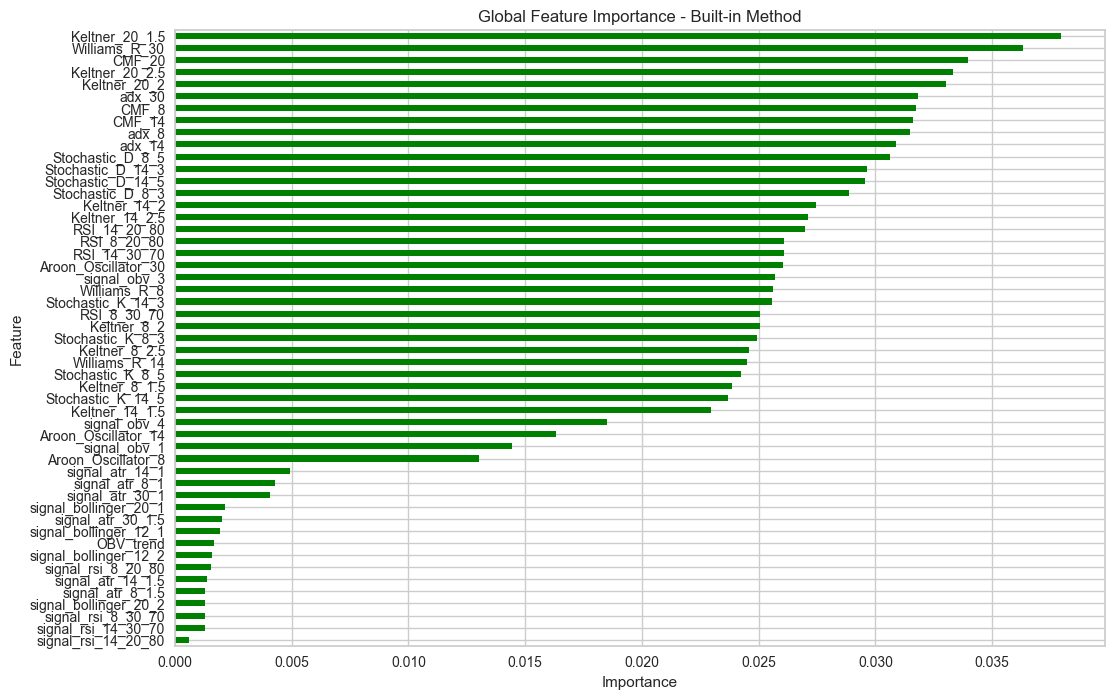

In [10]:
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green', figsize=(12, 8))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

(0.11053002929687494, 0.004989074615948595, 0.00043179969584281476)
(0.3708500061035156, 0.009688513424962379, 0.0013089600810878444)


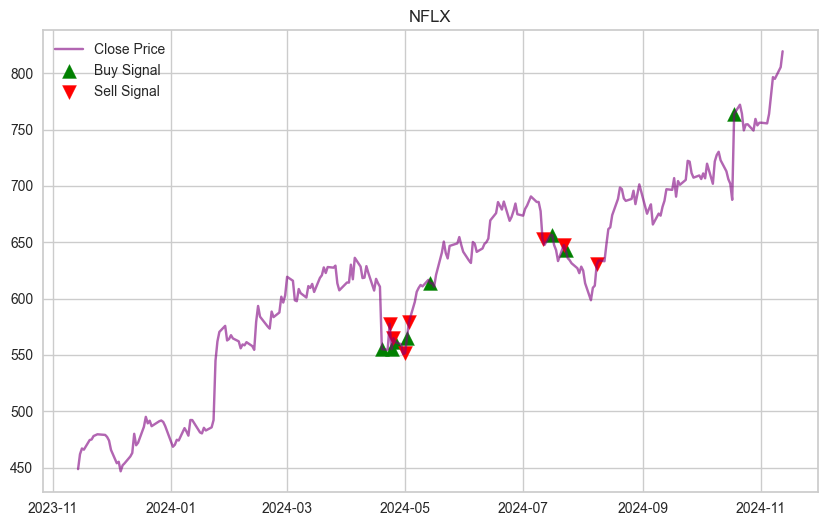

In [11]:
symbol = "NFLX"
df_test = data.filter(pl.col('period')=='test').filter(pl.col('Symbol')==symbol)
df_orders = ut.generate_orders(df_test, 1, 1000, clf, var)
print(ut.portfolio_stats(df_orders.portfolio_value))
print(ut.portfolio_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)

In [12]:
cum_return_1 = []
cum_return_2 = []
std_1 = []
std_2 = []
avg_return_1 = []
avg_return_2 = []
symbols_correct = []
for i in symbol_train:
    try:
        df_test = data.filter(pl.col('period')=='test').filter(pl.col('Symbol')==i)
        df_orders = ut.generate_orders(df_test, 1, 1000, clf, var)
        cum_return_1.append(ut.portfolio_stats(df_orders.portfolio_value)[0])
        cum_return_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[0])
        std_1.append(ut.portfolio_stats(df_orders.portfolio_value)[1])
        std_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[1])
        avg_return_1.append(ut.portfolio_stats(df_orders.portfolio_value)[2])
        avg_return_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[2])
        symbols_correct.append(i)
    except:
        print(i)

In [13]:
results = pd.DataFrame()
results['symbol'] = symbols_correct
results['cum_return_1'] = cum_return_1
results['cum_return_2'] = cum_return_2
results['std_1'] = std_1
results['std_2'] = std_2
results['avg_return_1'] = avg_return_1
results['avg_return_2'] = avg_return_2

In [14]:
results.describe()

,cum_return_1,cum_return_2,std_1,std_2,avg_return_1,avg_return_2
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.020202,0.056199,0.002912,0.004002,0.000087,0.000223
std,0.038635,0.084938,0.003202,0.004082,0.000146,0.000307
min,-0.059395,-0.077910,0.000364,0.000607,-0.000139,-0.000248
25%,-0.003710,0.007830,0.001110,0.001518,-0.000013,0.000045
50%,0.012865,0.033250,0.001711,0.002568,0.000052,0.000139
75%,0.030550,0.074863,0.003043,0.004894,0.000125,0.000292
max,0.110965,0.370850,0.017005,0.020518,0.000448,0.001309


In [15]:
results.sort_values('cum_return_2')

,symbol,cum_return_1,cum_return_2,std_1,std_2,avg_return_1,avg_return_2
17,ADBE,-0.041440,-0.077910,0.007762,0.012310,-0.000139,-2.484025e-04
35,SNOW,-0.018385,-0.040355,0.002626,0.004644,-0.000071,-1.539270e-04
10,INTC,-0.009900,-0.014729,0.000754,0.001046,-0.000040,-5.880712e-05
31,ROKU,-0.003710,-0.011480,0.002050,0.002687,-0.000013,-4.257140e-05
16,YELP,-0.003955,-0.006975,0.000545,0.000723,-0.000016,-2.773686e-05
25,SNAP,-0.005650,-0.000910,0.000513,0.000612,-0.000023,-3.454866e-06
36,ASML,-0.059395,-0.000851,0.017005,0.020518,-0.000098,2.096025e-04
15,MTCH,-0.001185,0.000110,0.000498,0.000834,-0.000005,7.864653e-07
20,CSCO,-0.000522,0.006823,0.000434,0.000638,-0.000002,2.740085e-05
22,LYFT,0.001400,0.007830,0.000364,0.000607,0.000006,3.138163e-05


# Other Classifiers

In [16]:
target = 'target_5'
data_train = data.filter(pl.col('period')=='train').select(var+[target]).to_pandas()
data_test= data.filter(pl.col('period')=='test').select(var+[target]).to_pandas()

In [17]:
exp_mclf101 = setup(data = data_train, target = target, session_id=1978, fix_imbalance=False) 

,Description,Value
0,Session id,1978
1,Target,target_5
2,Target type,Multiclass
3,Original data shape,"(35938, 52)"
4,Transformed data shape,"(35938, 52)"
5,Transformed train set shape,"(25156, 52)"
6,Transformed test set shape,"(10782, 52)"
7,Numeric features,51
8,Preprocess,True
9,Imputation type,simple


In [18]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5082,0.6032,0.5082,0.4607,0.4181,0.0809,0.1101,0.7780
gbc,Gradient Boosting Classifier,0.5056,0.5986,0.5056,0.4501,0.3883,0.0516,0.0865,12.7020
ada,Ada Boost Classifier,0.5054,0.5867,0.5054,0.4505,0.3951,0.0583,0.0907,0.8050
rf,Random Forest Classifier,0.5035,0.5914,0.5035,0.4547,0.4225,0.0814,0.1048,1.7500
lda,Linear Discriminant Analysis,0.5020,0.5763,0.5020,0.4466,0.3657,0.0289,0.0614,0.0450
ridge,Ridge Classifier,0.5018,0.0000,0.5018,0.4467,0.3631,0.0266,0.0587,0.0340
lr,Logistic Regression,0.5016,0.5760,0.5016,0.4487,0.3622,0.0259,0.0575,0.7130
dummy,Dummy Classifier,0.4993,0.5000,0.4993,0.2493,0.3325,0.0000,0.0000,0.0240
et,Extra Trees Classifier,0.4985,0.5948,0.4985,0.4494,0.4306,0.0876,0.1052,0.4630
knn,K Neighbors Classifier,0.4572,0.5370,0.4572,0.4062,0.4093,0.0436,0.0478,0.2890


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1978, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [19]:
nb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4976,0.5913,0.4976,0.4328,0.4008,0.0570,0.0797
1,0.5087,0.6110,0.5087,0.4654,0.4205,0.0826,0.1120
2,0.5052,0.6077,0.5052,0.4396,0.4164,0.0814,0.1068
3,0.5008,0.5898,0.5008,0.4567,0.4123,0.0671,0.0914
4,0.5143,0.6060,0.5143,0.4802,0.4238,0.0892,0.1240
5,0.5107,0.5981,0.5107,0.4600,0.4198,0.0860,0.1169
6,0.5109,0.6048,0.5109,0.4670,0.4170,0.0811,0.1139
7,0.5062,0.6081,0.5062,0.4527,0.4151,0.0776,0.1051
8,0.5185,0.6108,0.5185,0.4845,0.4331,0.1029,0.1376


In [20]:
cum_return_1 = []
cum_return_2 = []
std_1 = []
std_2 = []
avg_return_1 = []
avg_return_2 = []
symbols_correct = []
for i in symbol_train:
    try:
        df_test = data.filter(pl.col('period')=='test').filter(pl.col('Symbol')==i)
        df_orders = ut.generate_orders(df_test, 1, 1000, nb, var)
        cum_return_1.append(ut.portfolio_stats(df_orders.portfolio_value)[0])
        cum_return_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[0])
        std_1.append(ut.portfolio_stats(df_orders.portfolio_value)[1])
        std_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[1])
        avg_return_1.append(ut.portfolio_stats(df_orders.portfolio_value)[2])
        avg_return_2.append(ut.portfolio_stats(df_orders.portfolio_value_2)[2])
        symbols_correct.append(i)
    except:
        print(i)

In [21]:
results = pd.DataFrame()
results['symbol'] = symbols_correct
results['cum_return_1'] = cum_return_1
results['cum_return_2'] = cum_return_2
results['std_1'] = std_1
results['std_2'] = std_2
results['avg_return_1'] = avg_return_1
results['avg_return_2'] = avg_return_2

In [22]:
results.describe()

,cum_return_1,cum_return_2,std_1,std_2,avg_return_1,avg_return_2
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.025779,0.056199,0.002275,0.004002,0.000101,0.000223
std,0.056317,0.084938,0.002182,0.004082,0.000212,0.000307
min,-0.048100,-0.077910,0.000125,0.000607,-0.000191,-0.000248
25%,-0.002180,0.007830,0.000844,0.001518,-0.000008,0.000045
50%,0.006296,0.033250,0.001305,0.002568,0.000030,0.000139
75%,0.031465,0.074863,0.003607,0.004894,0.000125,0.000292
max,0.221330,0.370850,0.008216,0.020518,0.000822,0.001309


In [23]:
results.sort_values('cum_return_2')

,symbol,cum_return_1,cum_return_2,std_1,std_2,avg_return_1,avg_return_2
17,ADBE,0.031560,-0.077910,0.003607,0.012310,1.307552e-04,-2.484025e-04
35,SNOW,-0.009505,-0.040355,0.001883,0.004644,-3.643347e-05,-1.539270e-04
10,INTC,-0.011117,-0.014729,0.000571,0.001046,-4.455246e-05,-5.880712e-05
31,ROKU,0.009380,-0.011480,0.001547,0.002687,3.854043e-05,-4.257140e-05
16,YELP,0.003480,-0.006975,0.000148,0.000723,1.390687e-05,-2.773686e-05
25,SNAP,0.000810,-0.000910,0.000426,0.000612,3.328975e-06,-3.454866e-06
36,ASML,-0.014735,-0.000851,0.008216,0.020518,-2.592935e-05,2.096025e-04
15,MTCH,0.005580,0.000110,0.000570,0.000834,2.241987e-05,7.864653e-07
20,CSCO,0.011023,0.006823,0.000387,0.000638,4.392771e-05,2.740085e-05
22,LYFT,-0.000230,0.007830,0.000281,0.000607,-8.809350e-07,3.138163e-05


(0.2213300170898438, 0.006648226105713526, 0.0008220683201109713)
(0.3708500061035156, 0.009688513424962379, 0.0013089600810878444)


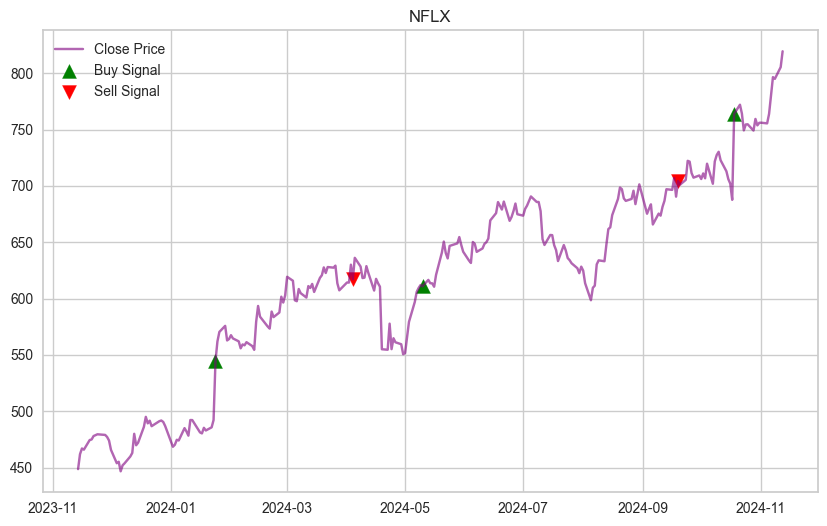

In [24]:
symbol = "NFLX"
df_test = data.filter(pl.col('period')=='test').filter(pl.col('Symbol')==symbol)
df_orders = ut.generate_orders(df_test, 1, 1000, nb, var)
print(ut.portfolio_stats(df_orders.portfolio_value))
print(ut.portfolio_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)